# 实验三：参数估计 & 非参数估计
* 姓名：彭钰婷
* 学号：2013631
* 专业：计算机科学与技术
## 实验要求
### 基本要求
生成两个各包含 N=1200 个二维随机向量的数据集合 X1 和 X2，数据集合中随机向量来自于三个分布模型，分别满足均值向量$\mu_1=[1,4]$，$\mu_2=[4,1]$，$\mu_3=[8,4]$和协方差矩阵$D_1=D_2=D_3=2I$，其中$I$I是2∗2的单位矩阵。在生成数据集合$X_1$时，假设来自三个分布模型的先验概率相同；而在生成数据集合$X_2$时，先验概率如下：$p(w_1)=0.6$，$p(w_2)=0.1$，$p(w_3)=0.3$
1. 在两个数据集合上分别应用“似然率测试规则”、“最大后验概率规则”进行分类实验，计算分类错误率，分析实验结果。
2. 在两个数据集合上分别应用$h=1$时的方窗核函数或高斯核函数估计方法，应用“似然率测试规则”进行分类实验，计算分类错误率，分析实验结果。

### 中级要求
根据初级要求中使用的一个核函数，在数据集$X_2$上应用交叉验证法，在$h∈[0.1,0.5,1,1.5,2]$中寻找最优的$h$值。
### 高级要求
任选一个数据集，在该数据集上应用k-近邻概率密度估计，任选3个k值输出概率密度分布图。

## 实验流程
### 生成数据集

In [24]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [25]:
# 生成正态分布数据
def Generate_Sample_Gaussian(mean, cov, P, label):
    '''
        mean 为均值向量
        cov 为方差矩阵a
        P 为单个类的先验概率
        return 单个类的数据集
    '''
    temp_num = round(1200 * P)
    x, y = np.random.multivariate_normal(mean, cov, temp_num).T
    z = np.ones(temp_num) * label
    X = np.array([x, y, z])
    return X.T

In [26]:
def Generate_DataSet_plot(mean, cov, P):
    # 画出不同先验对应的散点图
    xx = []
    label = 1
    for i in range(3):
        xx.append(Generate_Sample_Gaussian(mean[i], cov, P[i], label))
        label += 1
        i = i + 1
    # 画图
    plt.figure()
    for i in range(3):
        plt.plot(xx[i][:, 0], xx[i][:, 1], '.', markersize=4.)
        plt.plot(mean[i][0], mean[i][1], 'r*')
    plt.show()
    return xx

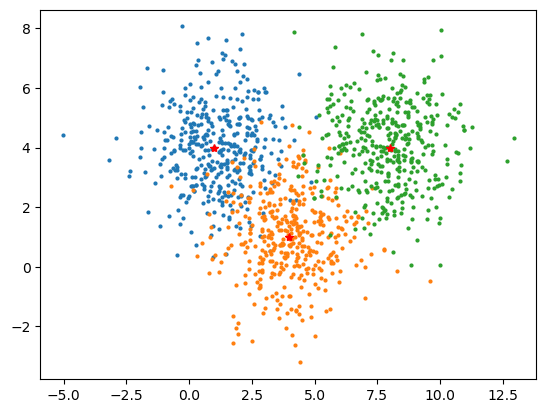

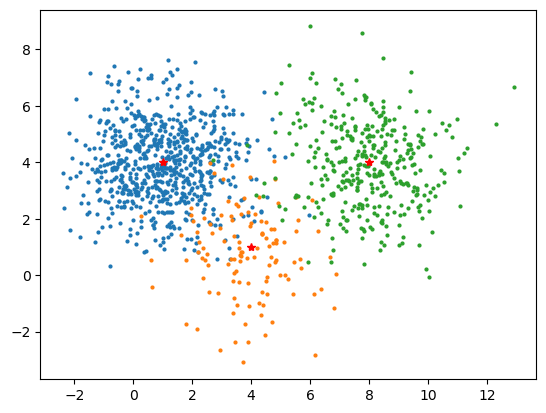

In [27]:
mean = np.array([[1, 4], [4, 1], [8, 4]])  # 均值数组
cov = [[2, 0], [0, 2]]  # 方差矩阵
num = 1200  # 样本个数
P1 = [1 / 3, 1 / 3, 1 / 3]  # 样本X1的先验概率
P2 = [0.6, 0.1, 0.3]  # 样本X2的先验概率
X1 = np.array(Generate_DataSet_plot(mean, cov, P1), dtype=object)
X2 = np.array(Generate_DataSet_plot(mean, cov, P2), dtype=object)
X1 = np.vstack(X1)
X2 = np.vstack(X2)

In [28]:
X1.shape, X2.shape  # 前两列是坐标，最后一列是标签

((1200, 3), (1200, 3))

# 1 基本要求
## 1.1 似然率&最大后验分类
### 1.1.1 计算mu和sigma

In [29]:
# 极大似然估计
# 输入n*2维数据
def LikelyHood(X):
    mu = [[0, 0], [0, 0], [0, 0]]
    classcnt = [0, 0, 0]
    for each in X:
        mu[int(each[2])-1][0] += each[0]
        mu[int(each[2])-1][1] += each[1]
        classcnt[int(each[2]-1)] += 1
    for i in range(len(mu)):
        mu[i][0] /= classcnt[i]
        mu[i][1] /= classcnt[i]
    mu = np.array(mu)
#     mu = np.mean(X, axis=0)
    # python把向量转化成矩阵需要用reshape
    cov = np.array([np.dot((X[i][0:2] - mu[int(X[i][2])-1]).reshape(2,1), (X[i][0:2] - mu[int(X[i][2])-1]).reshape(1, 2)) for i in range(len(X))]).mean(axis=0)
    return mu, cov

In [30]:
mu1,cov1 = LikelyHood(X1)
print("X1的mu为{0}:".format(mu1))
cov1 = cov1.tolist()
print("X1的cov为{0}:".format(cov1))
mu2,cov2 = LikelyHood(X2)
print("X2的mu为{0}:".format(mu2))
cov2 = cov2.tolist()
print("X2的cov为{0}:".format(cov2))

X1的mu为[[1.09299706 4.00319736]
 [3.99305095 1.03393789]
 [7.95390362 4.08767865]]:
X1的cov为[[2.0292427857365527, -0.023966710715365023], [-0.023966710715365023, 1.936551497016723]]:
X2的mu为[[1.00620902 3.95968371]
 [3.85684157 0.76522771]
 [7.9290327  3.94717619]]:
X2的cov为[[1.9900889176475591, -0.07881699400265217], [-0.07881699400265217, 2.009591794390559]]:


### 1.1.2 应用“似然率测试规则”分类
一元正态分布的概率密度计算公式为$\frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{(\theta - \mu)^2}{2\sigma^2}}$，其中$\sigma$为样本标准差，$\mu$为样本均值。本次实验中的数据样本均含2维特征，因此引入多元正态分布。各维度的数据点描述为$x=[x_1,x_2,...,x_d]^T$(本次实验d=2)，样本均值定义为$\mu=[\mu_1,\mu_2,...,\mu_d]$，方差定义为$\sigma=[\sigma_1,\sigma_2,..,\sigma_d]$。考虑到各维度间的相关性，引入协方差$Cov=\Sigma$。
因此，多元正态分布的概率密度函数为$f(x)=\frac{1}{(2\pi)^{\frac{d}{2}}|\Sigma|^{\frac{1}{2}}}e^{-\frac{1}{2}(X-\mu)^T\Sigma^{-1}(X-\mu)}$，其中$\Sigma$为协方差矩阵，$|\Sigma|$表示对其进行行列式运算。
在本实验中$d=2$，$\Sigma=Cov$，MLE估计函数为$f(x)=\frac{1}{2\pi|Cov|^{\frac{1}{2}}}e^{-\frac{1}{2}(X-\mu)^T(Cov)^{-1}(X-\mu)}$。

In [31]:
def compare(g1,g2,g3):
    if(g1 >= g2 and g1 >= g3):
        return 1
    elif (g2 >= g1 and g2 >= g3):
        return 2
    else:
        return 3

In [32]:
import math
import pandas as pd

In [33]:
def MLE(u,cov,x):
    x = np.array(x)
    u = np.array(u)
    x_u_list = []
    x_u_list.append([])
    x_u_list[0].append((x-u)[0])
    x_u_list.append([])
    x_u_list[1].append((x-u)[1])
    x_u_array = np.array(x_u_list)# x-u
    return 1/(2*np.pi*np.sqrt(np.linalg.det(cov)))*np.exp((-(1/2) * x_u_array.T).dot(np.mat(cov).I).dot(x_u_array))

In [34]:
def MLEClassifier(X,mu,cov):
    err = 0    
    for each in X:
        myx = []
        myx.append(each[0])
        myx.append(each[1])
        g1 = MLE(mu[0],cov,myx)
        g2 = MLE(mu[1],cov,myx)
        g3 = MLE(mu[2],cov,myx)
        res = compare(g1,g2,g3)
        if(res != each[2]):
            err += 1
    err /= len(X)
    return err

In [35]:
np.seterr(divide='ignore', invalid='ignore')  # 消除被除数为0的警告
err1 = MLEClassifier(X1,mu1,cov1)
err2 = MLEClassifier(X2,mu2,cov2)
print("似然率测试规则，数据集X1，err rate：",err1)
print("似然率测试规则，数据集X2，err rate：",err2)

似然率测试规则，数据集X1，err rate： 0.06583333333333333
似然率测试规则，数据集X2，err rate： 0.056666666666666664


### 1.1.3 应用“最大后验概率规则”分类
最大后验与极大似然的区别在于同时考虑了样本的先验概率，其函数为$f(x)=\frac{1}{(2\pi)^{\frac{d}{2}}|\Sigma|^{\frac{1}{2}}}e^{-\frac{1}{2}(X-\mu)^T\Sigma^{-1}(X-\mu)}p$，其中$\Sigma$为协方差矩阵，$|\Sigma|$表示对其进行行列式运算，$p$为样本中不同分布模型的先验概率。
在本实验中$d=2$，$\Sigma=Cov$，MLE估计函数为$f(x)=\frac{1}{2\pi|Cov|^{\frac{1}{2}}}e^{-\frac{1}{2}(X-\mu)^T(Cov)^{-1}(X-\mu)}p$。

In [36]:
def MAP(u,cov,x,p):
    x = np.array(x)
    u = np.array(u)
    x_u_list = []
    x_u_list.append([])
    x_u_list[0].append((x-u)[0])
    x_u_list.append([])
    x_u_list[1].append((x-u)[1])
    x_u_array = np.array(x_u_list)# x-u
    return 1/(2*np.pi*np.sqrt(np.linalg.det(cov)))*np.exp((-(1/2) * x_u_array.T).dot(np.mat(cov).I).dot(x_u_array))*p

In [37]:
def MAPClassifier(X,cov,plist):
    err = 0    
    for each in X:
        myx = []
        myx.append(each[0])
        myx.append(each[1])
        g1 = MAP([1,4],cov,myx,plist[0])
        g2 = MAP([4,1],cov,myx,plist[1])
        g3 = MAP([8,4],cov,myx,plist[2])
        res = compare(g1,g2,g3)
        if(res != each[2]):
            err += 1
    err /= len(X)
    return err

In [38]:
np.seterr(divide='ignore', invalid='ignore')  # 消除被除数为0的警告
err1 = MAPClassifier(X1,cov1,[1/3,1/3,1/3])
print("最大后验概率规则，数据集X1，err rate：",err1)
err2 = MAPClassifier(X2,cov2,[0.6,0.1,0.3])
print("最大后验概率规则，数据集X2，err rate：",err2)

最大后验概率规则，数据集X1，err rate： 0.065
最大后验概率规则，数据集X2，err rate： 0.0475


### 1.1.4 结果分析
分析函数表达式可知，最大后验预测比极大似然预测多乘了一项先验概率，考虑因素更齐全，因此对于[0.6,0.1,0.3]分布的样本，最大后验预测的错误率更低。而对于[1/3,1/3,1/3]先验概率相同的样本，由于预测各类时都乘以相同的数1/3，故极大似然和最大后验预测的错误率一样。

## 1.2 高斯核函数
### 1.2.1 应用“似然率测试规则”分类
使用高斯核函数，其密度函数计算式为$p(x)=\frac{1}{N}\Sigma_{n=1}^{N}\frac{1}{\sqrt{2\pi h^2}}exp^{-\frac{\|x-x_n\|^2}{2h^2}}$。例如，要计算样本$x_i=(a_i,b_i)$在类别1上的概率密度，则代入$N$为类别1的样本数，$h$为可调参数，$x$为$x_i$，$x_n=(a_n,b_n)$为类别1中当前遍历到的样本，$\|x-x_n\|^2=(a_i-a_n)^2+(b_i-b_n)^2$。由此可写出下列代码：

In [39]:
def KDE(xi,X,label,h):
    total = len(X)#训练集数据总数
    pi = 0
    N = 0
    for i in range(total):
        if X[i][2] == label:
            N += 1
            xn1 = X[i][0]
            xn2 = X[i][1]
            pi += (1/(np.sqrt(2*np.pi)*h))*np.exp(-0.5*((xi[0]-xn1)**2+(xi[1]-xn2)**2)/(h**2))
    pi /= N
    return pi

In [40]:
def KDEClassifier(test_X,train_X,h):
    err = 0    
    for each in test_X:# 对测试集每个样本分类
        myx = []
        myx.append(each[0])
        myx.append(each[1])
        g1 = KDE(myx,train_X,1,h)
        g2 = KDE(myx,train_X,2,h)
        g3 = KDE(myx,train_X,3,h)
        res = compare(g1,g2,g3)
        if(res != each[2]):
            err += 1
    err /= len(test_X)
    return err

In [41]:
np.seterr(divide='ignore', invalid='ignore')  # 消除被除数为0的警告
h=1
err1 = KDEClassifier(X1,X1,h)
print("高斯核函数，数据集X1，err rate：",err1)
err2 = KDEClassifier(X2,X2,h)
print("高斯核函数，数据集X2，err rate：",err2)

高斯核函数，数据集X1，err rate： 0.065
高斯核函数，数据集X2，err rate： 0.059166666666666666


### 1.2.2 结果分析
对比上述3种方法的error rate，结果如下表所示。

|  | MLE(极大似然)   | MAP(最大后验)  | KDE(核密度)  |
|  ----  | ----  |  ----  |  ----  |
| 数据集1| 7.4167%  | 7.5% |  7.0% |
| 数据集2| 5.6667%  | 4.4167% |  5.75% |

可以看到，三种方法的错误率都非常低，这是因为以高斯分布生成数据，在预测时又运用了高斯分布的概率密度函数计算。MAP由于多考虑了先验概率这一因素，在数据集2上表现最好，KDE在数据集1上表现最好，其中数据集1的MLE和MAP结果相等是由于生成数据时，假设了来自三个模型的先验概率相同。

# 2 中级要求
使用十折交叉验证寻找最佳h值。

## 2.1 划分数据集
在划分时，为保持数据分布的一致性，保持样本类别比例相似，采用分层采样的方式。对于X1，由于三类样本各400个，测试集大小120，因此每类样本取40个组成测试集；对于X2，由于三类样本比例为6：1：3，故120大小的测试集中，72个来自类别1，12个来自类别2，36个来自类别3。

In [42]:
def istest(i,startlist,sizelist):# 验证所给数据是否应在此次测试集中
    if(i >= startlist[0] and i < startlist[0] + sizelist[0]):
        return 1
    if(i >= startlist[1] and i < startlist[1] + sizelist[1]):
        return 1
    if(i >= startlist[2] and i < startlist[2] + sizelist[2]):
        return 1
    return 0

In [43]:
# 实现分层采样
def stratify(X, startlist, sizelist):
    test_X = []
    train_X = []
    for i in range(X.shape[0]):
        if(istest(i,startlist,sizelist)):
            test_X.append(list(X[i]))
        else:
            train_X.append(list(X[i]))
    test_X = np.array(test_X)
    train_X = np.array(train_X)
    return test_X,train_X

In [44]:
def validation(test_X1, train_X1, test_X2, train_X2,h):
    error1 = [0, 0, 0, 0, 0]
    error2 = [0, 0, 0, 0, 0]
    for i in range(len(h)):
        error1[i] = KDEClassifier(test_X1, train_X1, h[i])
        error2[i] = KDEClassifier(test_X2, train_X2, h[i])
    return error1, error2

In [45]:
def update(startlist,sizelist):# 更新startlist
    for i in range(len(startlist)):
        startlist[i] += sizelist[i]

## 2.2 十折交叉验证

In [46]:
np.seterr(divide='ignore', invalid='ignore')  # 消除被除数为0的警告
h=[0.1,0.5,1,1.5,2]
startlist1 = [0, 400, 800]
sizelist1 = [40, 40, 40]
startlist2 = [0, 720, 840]
sizelist2 = [72, 12, 36]
error1 = [0, 0, 0, 0, 0]
error2 = [0, 0, 0, 0, 0]
for i in range(10):# 十折交叉验证
    # 生成本次交叉验证所需测试集和训练集
    test_X1, train_X1 = stratify(X1, startlist1, sizelist1)
    test_X2, train_X2 = stratify(X2, startlist2, sizelist2)
    update(startlist1,sizelist1)
    update(startlist2,sizelist2)
    # 获取error rate
    tmp1, tmp2 = validation(test_X1,train_X1, test_X2, train_X2,h)
    # 和之前的error rate对应(不同h)相加
    for i in range(len(h)):
        error1[i] += tmp1[i]
        error2[i] += tmp2[i]
# 计算最终error rate
for i in range(len(h)):
    error1[i] /= 10
    error2[i] /= 10
    print('h={0}时，X1的error rate为{1}'.format(h[i], error1[i]))
    print('h={0}时，X2的error rate为{1}'.format(h[i], error2[i]))

h=0.1时，X1的error rate为0.10166666666666666
h=0.1时，X2的error rate为0.08249999999999999
h=0.5时，X1的error rate为0.07166666666666667
h=0.5时，X2的error rate为0.06333333333333334
h=1时，X1的error rate为0.06583333333333334
h=1时，X2的error rate为0.06333333333333332
h=1.5时，X1的error rate为0.06583333333333333
h=1.5时，X2的error rate为0.06083333333333333
h=2时，X1的error rate为0.06666666666666668
h=2时，X2的error rate为0.057499999999999996


## 2.3 选择最优h
经过多次实验发现，h=0.1时在X1、X2数据集始终表现最差，故舍去；舍去0.1后，h=0.5时在X1数据集始终表现最差，故舍去。接下来在1、1.5、2中选择。经统计，h=1.5时总体表现最好，故选择最优h=1.5。  
核密度函数估计参数h的选取非常重要。h过小，得出的概率密度函数不平滑，包含的噪声多；h过大，得出的概率密度函数过于平滑，包含的细节少。

# 3 高级要求
选择X1数据集，在该数据集上应用k-近邻概率密度估计，选择5、10、20三个k值，输出其概率密度分布图。

## 绘制概率密度分布图

In [47]:
def cal_distance(x1, y1, x2, y2):# 计算距离
    return np.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

In [48]:
def cal_V(distance):# 计算V，以最大距离为半径的圆面积
    return np.pi * (distance)*(distance)

In [49]:
def cal_p(k, n, V):
    return k / (n * V)

In [50]:
def Kneibor_Eval(X, k):
    num = len(X)
    Xtrain = np.array(X)
    # 生成200*200=40000个采样点，每个采样点对应三类的不同概率
    p = np.zeros((200, 200, 3))
    # 在[-5,15]的范围内，以0.1为步长估计概率密度
    for i in np.arange(0, 200):
        x = -5 + i * 0.1
        for j in np.arange(0, 200):
            '''
            # 生成标准差距离
            # 根据第k个数据点的位置计算V
            # 找到前k个数据点的类别,分别加到对应类的权重上
            # 计算每个采样点的概率密度函数
            
            '''
            y = -5 + j * 0.1
            # 1. 生成标准差距离
            distances = []
            for x1 in X:
                distance = cal_distance(x,y,x1[0],x1[1])
                distances.append(distance)
            k_distant_id = np.argsort(distances)[0:k]
            distances = np.array(distances)[k_distant_id]# distances中为最近的k个
            # 2. 根据第k个数据点的位置计算V
            V = cal_V(distances[k-1])
            # 3. 找到前k个数据点的类别,分别加到对应类的权重上
            # 求ki
            ki = [0, 0, 0]
            for idi in k_distant_id:
                ki[int(X1[idi][2])-1] += 1
            for z in range(0,3):
                p[i][j][z] = cal_p(ki[z], X.shape[0], V)
    return p

In [51]:
print("k=5")
p = Kneibor_Eval(X1, 5)  # 获得概率密度估计

# 高级要求1
X,Y = np.mgrid[-5:15:200j, -5:15:200j]

Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

k=5


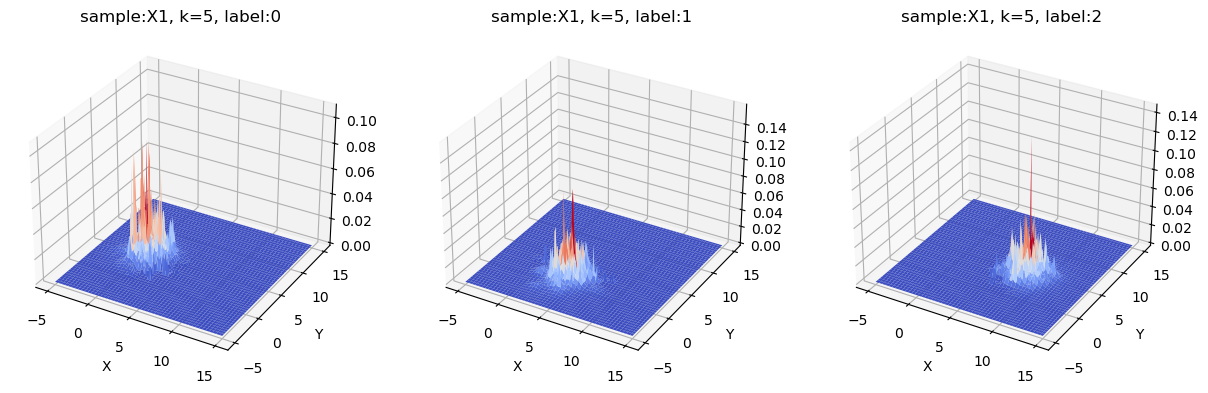

In [52]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=5, label:0")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=5, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=5, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

In [53]:
print("k=10")
p = Kneibor_Eval(X1, 10)  # 获得概率密度估计

# 高级要求1
X,Y = np.mgrid[-5:15:200j, -5:15:200j]

Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

k=10


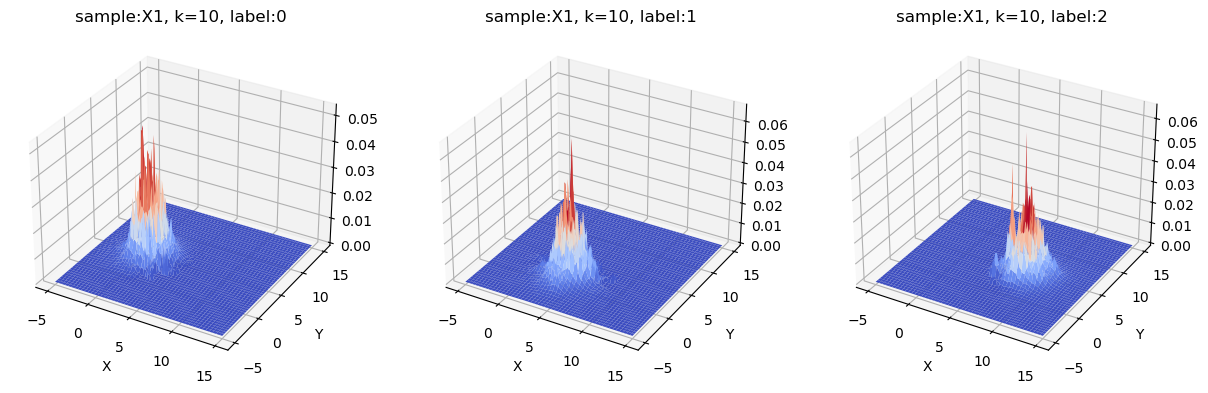

In [54]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=10, label:0")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=10, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=10, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

In [55]:
print("k=20")
p = Kneibor_Eval(X1, 20)  # 获得概率密度估计

# 高级要求1
X,Y = np.mgrid[-5:15:200j, -5:15:200j]

Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

k=20


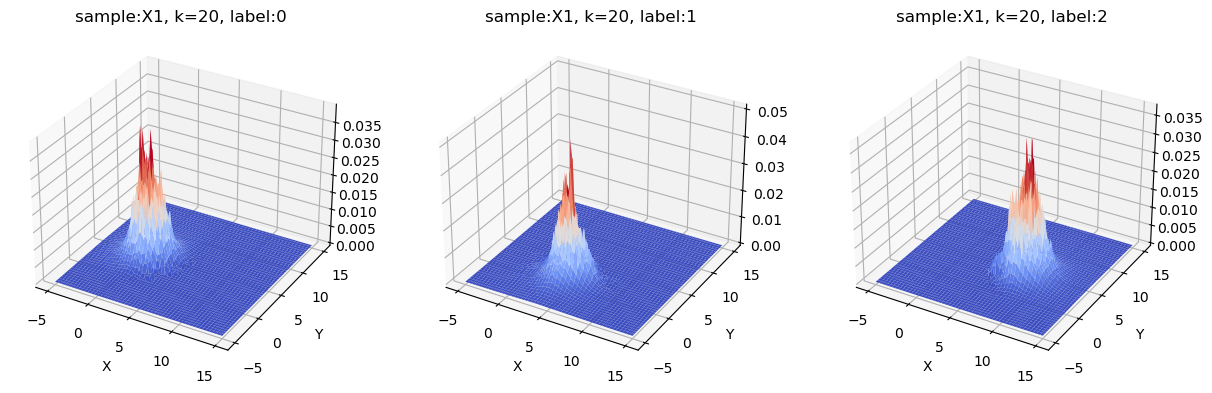

In [56]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=20, label:0")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=20, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=20, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()